In [ ]:
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw

base_path = '/Users/ironegg/PycharmProjects/scentificComp/cv_2'
wirebond = cv2.imread(os.path.join(base_path, 'initial_data/Wirebond.png'), cv2.IMREAD_GRAYSCALE)

In [2]:
def read_img(relative_path):
    img = cv2.imread(os.path.join(base_path, relative_path), cv2.IMREAD_GRAYSCALE)
    return img

In [3]:
def img_show(img, save=False, relative_path=None):
    plt.imshow(img, cmap='gray')
    if save:
        plt.savefig(os.path.join(base_path, relative_path))
    plt.show()

In [4]:
def imgs_plot(imgs, save=False, relative_path=None):
    """
    plot a set of figures.
    :param imgs: 2D array
    :param save: bool, whether to save the ploted figure.
    :param relative_path: string
    :return: None
    """
    n = len(imgs)
    fig = plt.figure(figsize=(15, 7))
    for i in range(n):
        plt.subplot(1, 3, i + 1)
        plt.imshow(imgs[i], cmap='gray')
    if save:
        plt.savefig(os.path.join(base_path, relative_path))
    plt.show()

## Opening and closing operation
In the opening operation processing, we do the corrosion then the expansion operation.
In the opening operation processing, we  rstly do the expansion then the corrosion operation.

In [5]:
def corrosion(img, kernel=None):
    """
    image corrosion operation.
    :param img: 2d array
    :param kernel: 2d array, structure element
    :return: image after corrision
    """
    if kernel is None:
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    kernel_size = kernel.shape[0]
    img_size = img.shape
    output_img = np.zeros(img_size)
    pad_size = kernel_size // 2
    img = np.pad(img, pad_size, 'constant', constant_values=0)
    for row in range(img_size[0]):
        for col in range(img_size[1]):
            if np.all(img[row:(row + kernel_size), col:(col + kernel_size)] * kernel):
                output_img[row, col] = 255
    return output_img



In [6]:
def expansion(img, kernel=None):
    """
    image expansion operation.
    :param img: 2d array
    :param kernel: 2d array, structure element
    :return: image after expansion
    """
    if kernel is None:
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    kernel_size = kernel.shape[0]
    img_size = img.shape
    output_img = np.zeros(img_size)
    pad_size = kernel_size // 2
    img = np.pad(img, pad_size, 'constant', constant_values=0)
    for row in range(img_size[0]):
        for col in range(img_size[1]):
            if np.any(img[row:(row + kernel_size), col:(col + kernel_size)] * kernel):
                output_img[row, col] = 255
    return output_img



In [7]:
def opening_operation(img, kernel=None):
    """
    image operation:corrision-->expansion.
    """
    cor_img = corrosion(img, kernel)
    exp_img = expansion(cor_img, kernel)
    return img, cor_img, exp_img

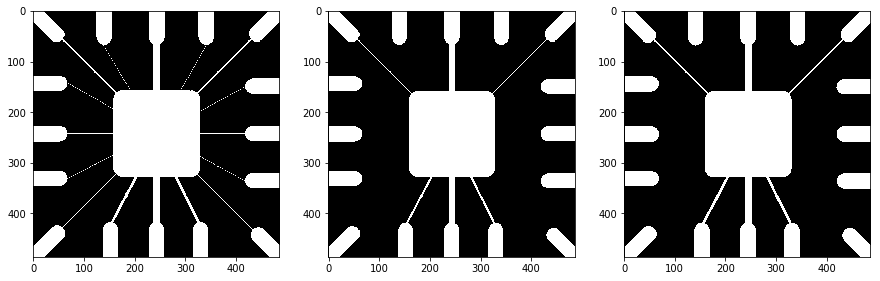

In [8]:
open_imgs = opening_operation(wirebond, np.ones((2, 2)))
imgs_plot(open_imgs, save=True, relative_path='output_data/open_img.png')

We can see that the thinnest lines in original  gure have been eliminated after corrosion operation. However, other lines are also thinner after the  rst operation. Then we implement the expansion operation, which make the thinner line become strong a bit.

In [9]:
def closing_operation(img, kernel=None):
    """
    image operation:expansion--->corrision.
    """
    exp_img = expansion(img, kernel)
    corr_img = corrosion(exp_img, kernel)
    return img, exp_img, corr_img

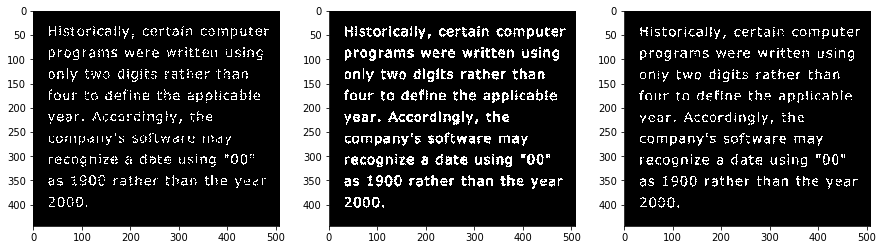

In [10]:
text_img = read_img('initial_data/Text.png')
closing_imgs = closing_operation(text_img, np.ones((2, 2)))
imgs_plot(closing_imgs, save=True, relative_path='output_data/closing_img.png')

We can see that pixels in each letters in original  gure have been more connected and the letters have been stronger after expansion operation. Then we implement the corrosion operation, which make the letters thinner.   
## Canny

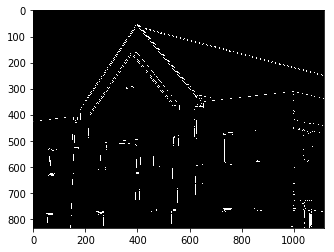

In [11]:
house = read_img('initial_data/House.png')
gauss_img = cv2.GaussianBlur(house, (5, 5), 1.4)
canny_img = cv2.Canny(gauss_img, threshold1=60, threshold2=245)
img_show(canny_img, save=True, relative_path='output_data/canny.png')

Using canny edge detector, the most signi cant lines, like the shape of the roof, are able to be detected.

## Hough Transform
We  first write a function to implement the hough transform algorithm which returns the voting accumulator and θ values.   
   
Then to detect lines, we write another function to select the k ρ-θ pairs which have the k largest scores recorded in the voting accumulator. Each pairs can draw a line and the number of votes means the number of points detected along the line.   
   
Since there are some noise points which may make the line longer unexpectedly. We write the third function called line- ltering to split the detected line and judge whether each piece is a true line in the  gure based on the distance between 2 consecutive points and the minimum number of point a true line shoud have. By the way, these two rules are written as two parameters so that we can adjust them to get a good result.


In [12]:
def hough_transform(img):
    """
    hough transform.
    :param img: 2d array
    :return:
    accumulator: voting results in rho-theta paramter space
    thetas: thetas values
    diag_len: the diagonal length of the input image, need it because
        the rho's range is[-diag_len, diag_len]

    """
    thetas = np.deg2rad(np.arange(-90.0, 180.0, 1))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator
    accumulator = np.zeros((2 * diag_len + 1, num_thetas))

    # (row, col) indexes to shape edges
    x_loc, y_loc = np.nonzero(img)

    # Vote in the hough accumulator
    for i in range(len(x_loc)):
        x = x_loc[i]
        y = y_loc[i]
        for t_idx in range(num_thetas):
            rho = diag_len + int(round(x * cos_theta[t_idx] + y * sin_theta[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, diag_len



In [13]:
hough_img = hough_transform(canny_img)

In [14]:
def line_filtering(line, dst_threshold=None, min_line_point=None):
    """
    filter the lines detected detected based on the hough accumulator.

    :param line: list,
        A set of points, each point contains
        its index (x, y).
    :param dst_threshold: float,
        If the distance between two consecutive points is
        larger than the threshold, then they will be seperated
        into two parts.
    :param min_line_point: int,
        If one part of lines has less number of points smaller than
        min_line_point, then this part of lines would not be consideres
        to be a true line.
    :return: list,
         Contains lines info which are regarded as true lines.
         each element contains a start point and a end point, as well
         as the number of detect points this line contains.
    """
    # sort the points based on the column index
    line = line[line[:, 1].argsort(), :]

    # compute the distance between two consecutive points
    dst_diff = np.sqrt(np.diff(line[:, 1]) ** 2 + np.diff(line[:, 0]) ** 2)

    # search index where the distance is beyond the distance threshold
    flags = np.argwhere(dst_diff > dst_threshold).ravel()
    pieces = len(flags)

    # the whole set of points are regarded as a true line
    if pieces == 0:
        return [{'pt1': line[0, :], 'pt2': line[-1, :], 'n_points': line.shape[0]}]

    start = 0
    line_set = []
    # split the points into pieces
    for idx in range(pieces + 1):
        if idx < pieces:
            end = flags[idx] + 1
            sub_line = line[start:end, :]
            start = end
        else:
            sub_line = line[flags[-1]:, :]
        n_points = sub_line.shape[0]

        # to decide whether this subset should be a true line
        if n_points > min_line_point:
            pt1 = sub_line[0, :]
            pt2 = sub_line[-1, :]
            pt_pair = {'pt1': pt1, 'pt2': pt2, 'n_points': n_points}
            line_set.append(pt_pair)
    return line_set



In [15]:
def hough_detect_lines(img, accumulator, thetas, diag_len, k_lines,
                       dst_threshold=None, min_line_point=None):
    """

    :param img: 2d array
    accumulator: 2d array,
        Voting results in rho-theta paramter space
    thetas: list, thetas values
    diag_len: int, the diagonal length of the input image, need it because
        in fact we plus rho and diag_len to guarantee the rho's
        value is not negative.
    :param k_lines: choose the first k lines which has the k
        largest votes.
    :param dst_threshold: used in line_filtering function to
        seperate point set
    :param min_line_point: used in line_filtering function to decide
        a true line.
    :return:list, a set of true lines
    """

    # sort array according the accumulator element value
    x, y = np.unravel_index(np.argsort(accumulator, axis=None),
                            accumulator.shape)

    # extract the first k pairs of rho and theta
    extract_x = x[-k_lines:]
    extract_y = y[-k_lines:]
    rhos_p_diaglen = extract_x
    theta = thetas[extract_y]

    #  compute sin and cos
    sin_thetas = np.sin(theta)
    cos_thetas = np.cos(theta)

    # lines info container
    lines = []

    # extract the element location which value is nonzero
    x_idxs, y_idxs = np.nonzero(img)

    # detect points for specific rho and theta
    for id_t, rho in enumerate(rhos_p_diaglen):
        detect_points = []
        sin_theta = sin_thetas[id_t]
        cos_theta = cos_thetas[id_t]
        for i in range(len(x_idxs)):
            x = x_idxs[i]
            y = y_idxs[i]
            inverse_rho = diag_len + int(round(x * cos_theta + y * sin_theta))
            if inverse_rho == rho:
                detect_points.append([x, y])
        detect_points = np.array(detect_points)
        line_set = line_filtering(detect_points, dst_threshold, min_line_point)
        lines.extend(line_set)
    return lines



In [16]:
detect_lines = hough_detect_lines(canny_img, *hough_img,
                                  k_lines=140,
                                  dst_threshold=25,
                                  min_line_point=15)

In [17]:
def hough_plot(img, lines, save=False):
    """
    plot detected line on the basic image.
    """
    color_img = np.array([img, img, img]).transpose((1, 2, 0))
    k_lines = len(lines)
    for i in range(k_lines):
        line_info = lines[i]
        pt1 = line_info['pt1']
        pt2 = line_info['pt2']
        rr, cc = draw.line(pt1[0], pt1[1], pt2[0], pt2[1])
        draw.set_color(color_img, [rr, cc], [0, 255, 0])
    plt.imshow(color_img)
    if save:
        plt.savefig(os.path.join(base_path, 'output_data/hough_img.png'))
    plt.show()


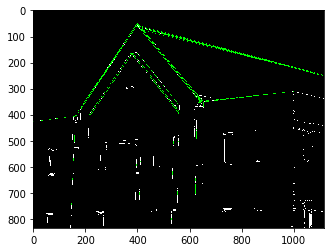

In [18]:
hough_plot(canny_img, detect_lines, save=True)

##  Boundary following algorithm

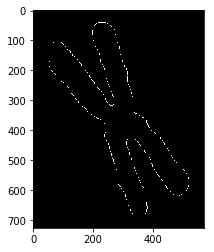

In [19]:
boundary = read_img('initial_data/Boundary_Following.png')
img_show(boundary)

In [20]:
def clockwise_search(row, col, begin=None):
    """
    Return 8-neighbor points in the clockwise direction.
    :param row: int, row index
    :param col: int, col index
    :param begin: list, begin point containing index
    :return: 8-neighbor points
    """
    if begin is None:
        begin = [row, col - 1]
    neighbor_loc = [[row, col - 1], [row - 1, col - 1], [row - 1, col],
                    [row - 1, col + 1], [row, col + 1], [row + 1, col + 1],
                    [row + 1, col], [row + 1, col - 1]]
    neighbor_loc.extend(neighbor_loc)
    flag = np.all(np.array(neighbor_loc) == begin, axis=1)
    flag_loc = np.argwhere(flag).ravel()
    target = neighbor_loc[flag_loc[0]:flag_loc[1]]
    return target

In [21]:
def boundary_detect(img):
    """
    Detect boundary of the image based on the boundary
    following algorithm.
    :param img: 2d array
    :return: list, a set of boundary points
    """
    begin_pt = np.unravel_index(np.argmax(img), img.shape)
    begin_pt = list(begin_pt)
    bound_points = [begin_pt]
    begin = None
    while True:
        neighbor_loc = clockwise_search(begin_pt[0], begin_pt[1], begin)
        loc_arr = np.array(neighbor_loc)
        neighbor_pts = img[loc_arr[:, 0], loc_arr[:, 1]]
        b_idx = np.argmax(neighbor_pts)
        b = neighbor_loc[b_idx]
        if len(bound_points) > 10 and begin_pt == bound_points[0] and b == bound_points[1]:
            break
        bound_points.append(b)
        begin = neighbor_loc[b_idx - 1]
        begin_pt = b
    return bound_points

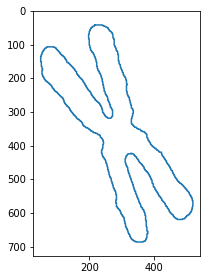

In [22]:
detect_boundary = boundary_detect(boundary)
detect_point = np.array(detect_boundary)
fig = plt.figure(figsize=(3, 4.5))
plt.plot(detect_point[:, 1], detect_point[:, 0])
plt.ylim(727, 0)
plt.savefig(os.path.join(base_path, 'output_data/boundary.png'))
plt.show()

## Flood fill algorithm
At the beginning we  find a point inside the boundary and add it to a stack, which is the  first step.   
Then take the last point in the stack and search its 4-neighbouring points. If all of its neighbouring points are white(value 255), then we pop this point. Ohterwise we add these black(value 0) neighbouring points to the stack and  fill them with white color.   
We implement the steps above except the  rst one until the stack is exhausted.

In [23]:
def neighbor_4(point):
    """
    Return 4-neighbouring points.
    """
    row, col = point[0], point[1]
    return [[row + 1, col], [row - 1, col], [row, col + 1], [row, col - 1]]

In [24]:
def flood_fill(img):
    """
    fill the image based on the flood fill algorithm.
    """
    begin_pt = np.unravel_index(np.argmax(img), img.shape)
    begin_pt = list(begin_pt)
    paint_img = np.copy(img)

    # find a point inside the boundary
    while True:
        begin_pt[0] = begin_pt[0] + 1
        begin_pt[1] = begin_pt[1] + 1
        if img[begin_pt[0], begin_pt[1]] == 0:
            paint_img[begin_pt[0], begin_pt[1]] = 255
            break

    # build a stack to contain points which need to be search
    Q = [begin_pt]
    while len(Q) > 0:
        node = Q[-1]
        neighbor_loc = neighbor_4(node)
        loc_arr = np.array(neighbor_loc)
        neighbor_pts = paint_img[loc_arr[:, 0], loc_arr[:, 1]]
        flag = neighbor_pts == 0

        # whether all neighbors value has filled
        if np.sum(flag) == 0:
            tmp = Q.pop()
            continue

        # fill the neighbor points which is black(0)
        to_fill_neighbor = loc_arr[flag, :]
        paint_img[to_fill_neighbor[:, 0], to_fill_neighbor[:, 1]] = 255
        Q.extend(to_fill_neighbor.tolist())
    return paint_img



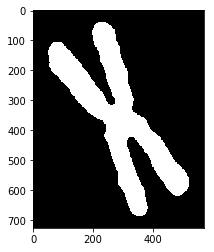

In [25]:
paint_img = flood_fill(boundary)

img_show(paint_img, save=True, relative_path='output_data/fill_img.png')
